In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')
from kneed import KneeLocator
from sklearn.metrics import r2_score
from colorama import Fore, Style

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

In [3]:
def break_point_solution(stock_name):
    '''
    Solve for the break point solution price for breaking the current MA/BB
    stock_name: str
    '''
    df = yf.download(stock_name.upper(),
                 start=(datetime.today() - relativedelta(days=100)).strftime('%Y-%m-%d'),
                 end=datetime.today()
                 )
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    df = df[['close']]
    
    # Define the expression whose roots we want to find
    # fsolve is not satisfying; provide analytical solution
    
    last_19day_price = df['close'][-20:-1]
    last_49day_price = df['close'][-50:-1]
    
    # func_20MA = lambda price : (np.sum(last_19day_price) + price)/20 - price
    # func_50MA = lambda price : (np.sum(last_49day_price) + price)/50 - price
    # func_20MA_UBB = lambda price : (np.sum(last_19day_price) + price)/20 + 2*np.sqrt((np.sum(last_19day_price**2) + price**2 - (np.sum(last_19day_price) + price)**2/20)/19) - price
    # func_20MA_LBB = lambda price : (np.sum(last_19day_price) + price)/20 - 2*np.sqrt((np.sum(last_19day_price**2) + price**2 - (np.sum(last_19day_price) + price)**2/20)/19) - price
    # func_50MA_UBB = lambda price : (np.sum(last_49day_price) + price)/50 + 2.5*np.sqrt((np.sum(last_49day_price**2) + price**2 - (np.sum(last_49day_price) + price)**2/50)/49) - price
    # func_50MA_LBB = lambda price : (np.sum(last_49day_price) + price)/50 - 2.5*np.sqrt((np.sum(last_49day_price**2) + price**2 - (np.sum(last_49day_price) + price)**2/50)/49) - price

    # func_20MA = lambda price : np.mean(np.append(last_19day_price, price)) - price
    # func_50MA = lambda price : np.mean(np.append(last_49day_price, price)) - price
    # func_20MA_UBB = lambda price : np.mean(np.append(last_19day_price, price)) + 2 * np.std(np.append(last_19day_price, price), ddof=1) - price
    # func_20MA_LBB = lambda price : np.mean(np.append(last_19day_price, price)) - 2 * np.std(np.append(last_19day_price, price), ddof=1) - price
    # func_50MA_UBB = lambda price : np.mean(np.append(last_49day_price, price)) + 2.5 * np.std(np.append(last_49day_price, price), ddof=1) - price
    # func_50MA_LBB = lambda price : np.mean(np.append(last_49day_price, price)) - 2.5 * np.std(np.append(last_49day_price, price), ddof=1) - price

    # price_initial_guess = df['close'].tolist()[-1]
    # price_solution = fsolve(func_20MA, price_initial_guess)
    # price_solution = fsolve(func_50MA, price_initial_guess)
    # price_solution = fsolve(func_20MA_UBB, price_initial_guess)
    # price_solution = fsolve(func_20MA_LBB, price_initial_guess)
    # price_solution = fsolve(func_50MA_UBB, price_initial_guess)
    # price_solution = fsolve(func_50MA_LBB, price_initial_guess)

    a1 = np.sum(last_19day_price)
    a2 = np.sum(last_19day_price**2)
    p_ma = np.mean(last_19day_price)
    p_ubb = (562*a1 + np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
    p_lbb = (562*a1 - np.sqrt((562*a1)**2 - 4*(5339*(99*a1**2-1600*a2))))/5339/2
    
    print('20MA break point:', p_ma.round(2))
    print('20MA Lower Bollinger Band break point:', p_lbb.round(2))
    print('20MA Upper Bollinger Band break point:', p_ubb.round(2))

    a1 = np.sum(last_49day_price)
    a2 = np.sum(last_49day_price**2)
    p_ma = np.mean(last_49day_price)
    p_ubb = (4177*a1 + np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
    p_lbb = (4177*a1 - np.sqrt((4177*a1)**2 - 4*(102336.5*(361.5*a1**2-15625*a2))))/102336.5/2
    
    print('50MA break point:', p_ma.round(2))
    print('50MA Lower Bollinger Band break point:', p_lbb.round(2))
    print('50MA Upper Bollinger Band break point:', p_ubb.round(2))

In [4]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def test_option_trading(stock_name,
                        start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
                        end=datetime.today().strftime('%Y-%m-%d'),
                        return_result=False,
                       ):

    # Step 0: download the stock
    df = yf.download(stock_name.upper(), start=start, end=end)
                     
    df = df.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    # Step 1: Moving average and Bollinger Band
    
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['50 Day MA'] = df['Close'].rolling(window=50).mean()
    df['50 Day STD'] = df['Close'].rolling(window=50).std()
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
    
    # Step 2: calculate RSI
    # RSI = 100 – [100 / ( 1 + (Average of Upward Price Change / Average of Downward Price Change ) ) ] over a window
    # default length of the window is most recent 14 trade days

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Step 3: Support and resistance calculation, using clustering
    
    df_plot = df[df['Date'] >= df['Date'].min() + relativedelta(years=1)]

    low_clusters = get_optimum_clusters(df_plot[(df_plot['Low']!=df_plot['Open'])&(df_plot['Low']!=df_plot['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df_plot[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df_plot[(df_plot['High']!=df_plot['Open'])&(df_plot['High']!=df_plot['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df_plot[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df_plot.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df_plot['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df_plot['High'].max()

    # Finally, output and plot 
    
    close = df_plot.iloc[-1]['Close']
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print("Latest 20 Day MA:", round(df_plot['20 Day MA'].tolist()[-1], 2))
    print("Latest Lower Bollinger Band, 20MA:", round(df_plot['Lower Band - 20MA'].tolist()[-1], 2))
    print("Latest Higher Bollinger Band, 20MA:", round(df_plot['Upper Band - 20MA'].tolist()[-1], 2))
    print("Latest 50 Day MA:", round(df_plot['50 Day MA'].tolist()[-1], 2))
    print("Latest Lower Bollinger Band, 50MA:", round(df_plot['Lower Band - 50MA'].tolist()[-1], 2))
    print("Latest Higher Bollinger Band, 50MA:", round(df_plot['Upper Band - 50MA'].tolist()[-1], 2))

    latest_rsi = round(df['RSI'].tolist()[-1], 2)
    if latest_rsi > 70:
        print("Latest RSI:", Fore.RED + str(latest_rsi))
    elif latest_rsi < 30:
        print("Latest RSI:", Fore.GREEN + str(latest_rsi))
    else:
        print("Latest RSI:", latest_rsi)
        
    print(Style.RESET_ALL)
    break_point_solution(stock_name)
    
    print(low_centers)
    print(high_centers)
    
    ax = plot_candlestick(df_plot, figsize=(32,8))
    ax.set_title(stock_name)
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')
    # df_plot['5_MA'] = df_plot['Close'].rolling(window=5).mean()
    # df_plot['9_MA'] = df_plot['Close'].rolling(window=9).mean()
    # df_plot['20_MA'] = df_plot['Close'].rolling(window=20).mean()
    # df_plot['50_MA'] = df_plot['Close'].rolling(window=50).mean()

    # ax.plot(df_plot['Date'], df_plot['Close'], color='black')
    # ax.plot(df_plot['Date'], df_plot['5_MA'], ls='--')

    # ax.plot(df_plot['Date'], df_plot['9_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['20_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['50_MA'], ls='--')
    ax.plot(df_plot['Date'], df_plot['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 20MA'], df_plot['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
    ax.plot(df_plot['Date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

    ax.legend()

    if return_result:
        return df_plot

## Test effectiveness of support and resistance in option trading

### Strategy 1:
* Touch support: long call
* Touch resistance: long put

#### Fail

### Strategy 2:

* Touch support
    * reflect: long call
    * break: long put
* Touch resistance:
    * reflect: long put
    * break: long call
    
#### Key question: how to confirm break / reflect?

* Base assumption: assume the support and resistance to hold, unless strong conflict signal observed.
* Assumption1.1: when going down, a short red line / long green line confirm reflect; long red line confirm break
* Assumption1.2: when going up, a short green line / long red line confirm reflect; long green line confirm break
* ~~Read from 1-min Candlestick~~ -- not applicable
* Check if trend is align with QQQ/SPY


#### Stop revenue needed; for conservative, start with 20%.

#### Precision of level should be relative to the stock price.

#### Hard to validate/'

### Strategy 3: 

* Touch support / resistance: check with the daily price range, 95% confidence

QQQ & TQQQ

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 425.84 ~ up 429.14 , down 425.02
Latest 20 Day MA: 440.49
Latest Lower Bollinger Band, 20MA: 429.16
Latest Higher Bollinger Band, 20MA: 451.81
Latest 50 Day MA: 437.94
Latest Lower Bollinger Band, 50MA: 423.73
Latest Higher Bollinger Band, 50MA: 452.15
Latest RSI: 31.28

[*********************100%%**********************]  1 of 1 completed
20MA break point: 440.31
20MA Lower Bollinger Band break point: 426.93
20MA Upper Bollinger Band break point: 453.7
50MA break point: 438.15
50MA Lower Bollinger Band break point: 423.15
50MA Upper Bollinger Band break point: 453.15
[[317.7219986 ]
 [332.90222168]
 [348.75562477]
 [357.35933329]
 [365.96600037]
 [374.84413621]
 [387.31217359]
 [405.00347768]
 [425.02565201]
 [437.90341829]]
[[322.01714507]
 [336.72285679]
 [354.1288893 ]
 [363.17333272]
 [370.51714303]
 [377.66769174]
 [388.66370533]
 [407.68719971]
 [429.13739014]
 [442.8879

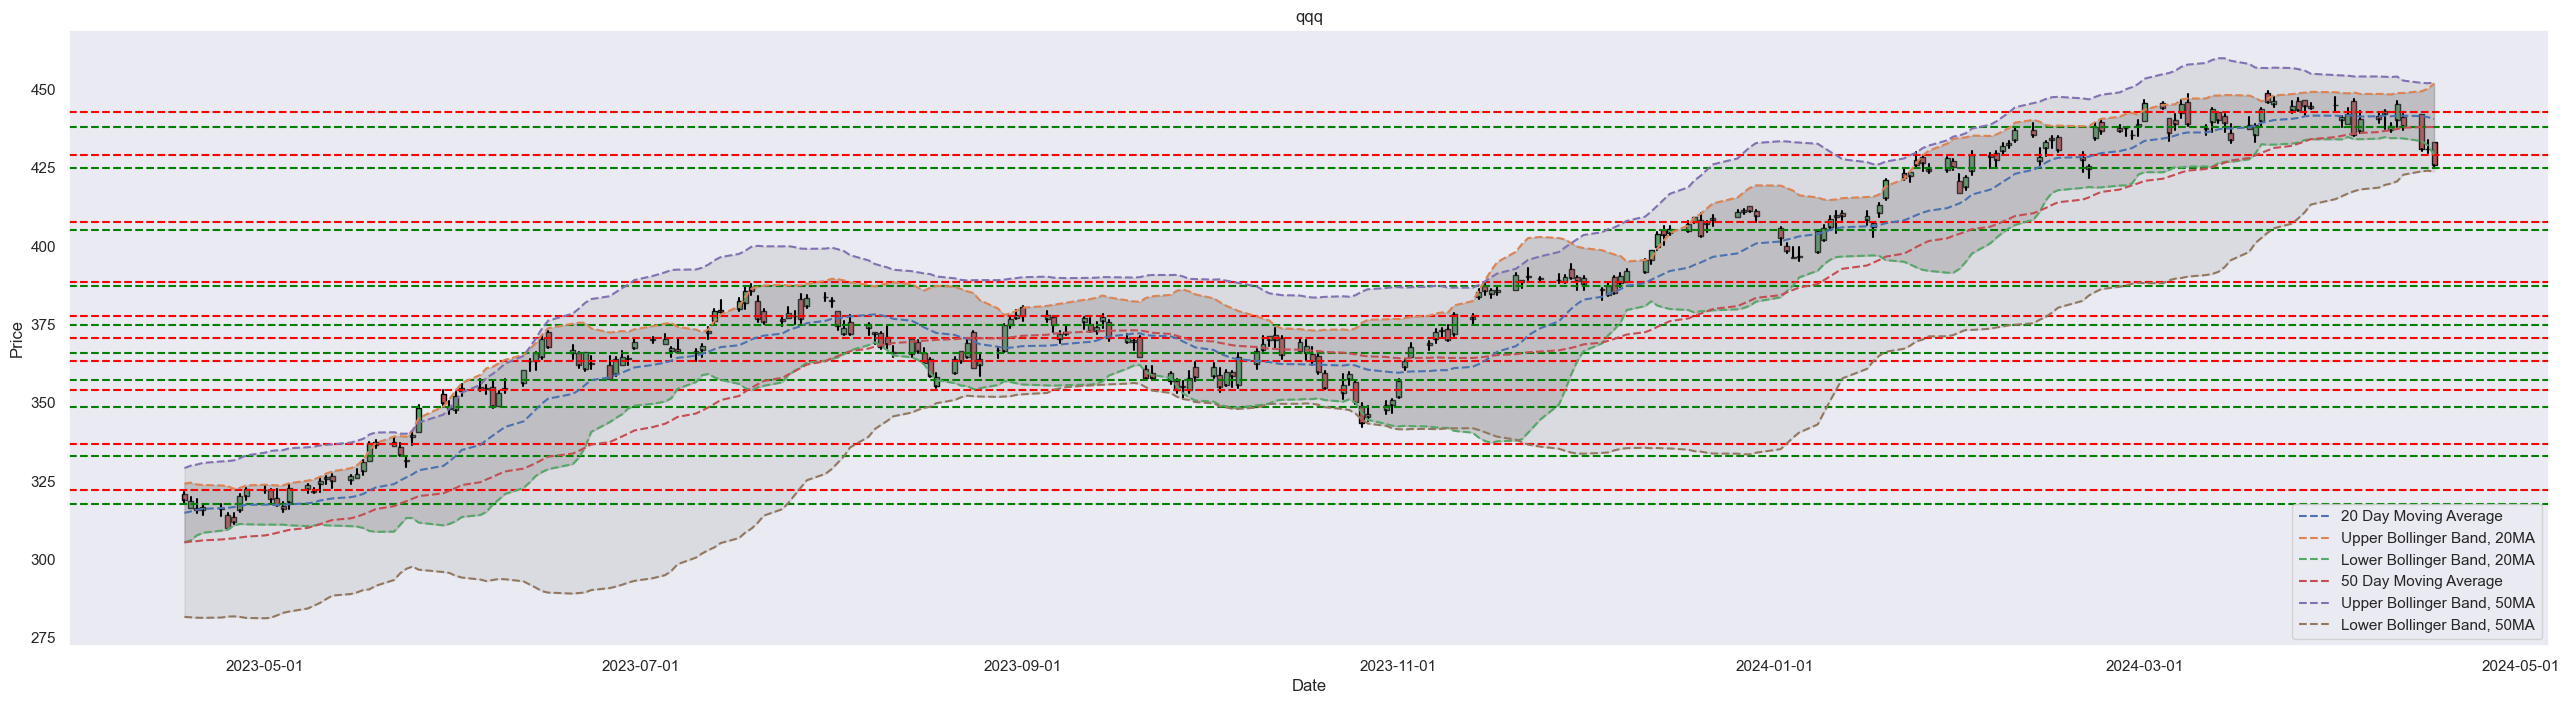

In [5]:
test_option_trading('qqq')

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 53.71 ~ up 56.57 , down 49.11
Latest 20 Day MA: 59.97
Latest Lower Bollinger Band, 20MA: 54.97
Latest Higher Bollinger Band, 20MA: 64.96
Latest 50 Day MA: 59.61
Latest Lower Bollinger Band, 50MA: 54.31
Latest Higher Bollinger Band, 50MA: 64.91
Latest RSI: 30.15

[*********************100%%**********************]  1 of 1 completed
20MA break point: 59.88
20MA Lower Bollinger Band break point: 54.0
20MA Upper Bollinger Band break point: 65.76
50MA break point: 59.67
50MA Lower Bollinger Band break point: 53.99
50MA Upper Bollinger Band break point: 65.35
[[27.22954542]
 [31.63846207]
 [35.39457147]
 [38.64090893]
 [41.78176476]
 [44.58000011]
 [49.11499996]
 [54.63052589]
 [58.50687528]
 [61.25545467]]
[[28.1171429 ]
 [32.09454536]
 [36.42032242]
 [39.61809494]
 [42.40705883]
 [45.41620675]
 [50.55952381]
 [56.56388834]
 [60.10479935]
 [62.6522221 ]]


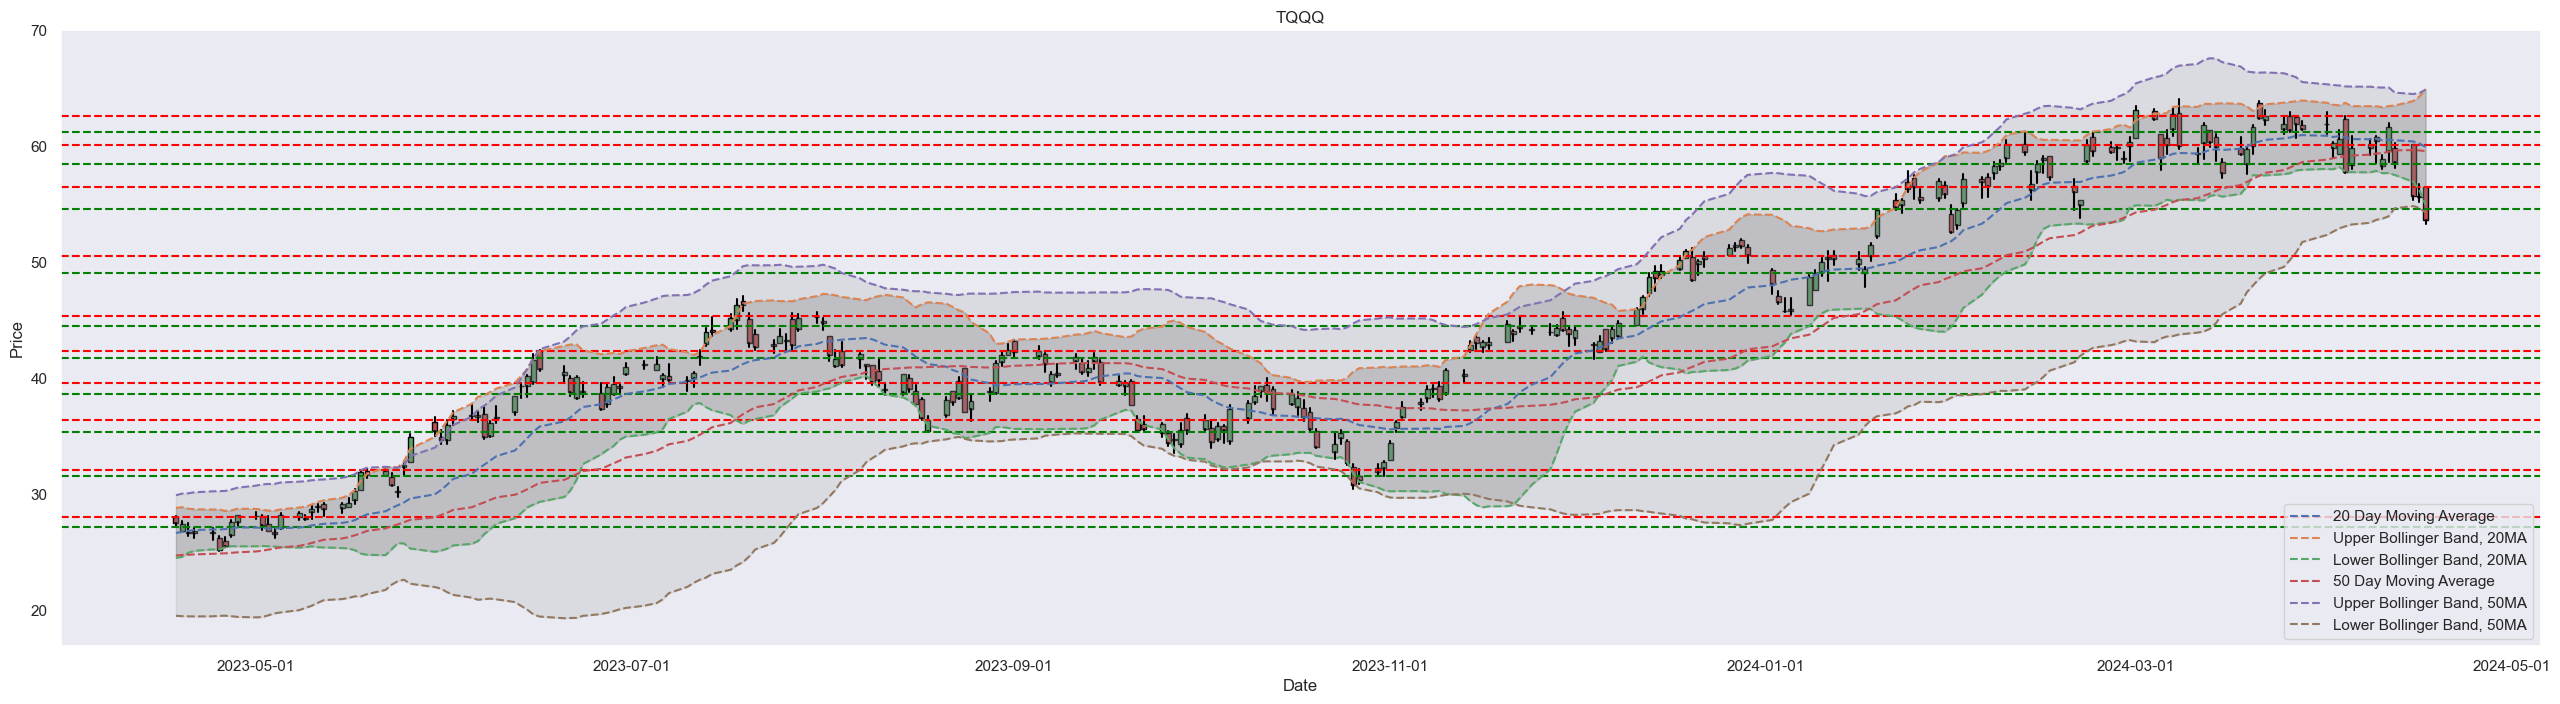

In [6]:
# 90% profit put: 53
test_option_trading('TQQQ')

SPY & UPRO

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 500.55 ~ up 509.84 , down 497.05
Latest 20 Day MA: 516.51
Latest Lower Bollinger Band, 20MA: 503.08
Latest Higher Bollinger Band, 20MA: 529.93
Latest 50 Day MA: 510.39
Latest Lower Bollinger Band, 50MA: 489.15
Latest Higher Bollinger Band, 50MA: 531.63
Latest RSI: 24.31

[*********************100%%**********************]  1 of 1 completed
20MA break point: 516.3
20MA Lower Bollinger Band break point: 500.44
20MA Upper Bollinger Band break point: 532.16
50MA break point: 510.72
50MA Lower Bollinger Band break point: 488.41
50MA Upper Bollinger Band break point: 533.04
[[410.54781246]
 [422.23538325]
 [433.7605011 ]
 [443.73249912]
 [452.89360894]
 [470.99920166]
 [486.38916779]
 [497.05749512]
 [508.62260901]
 [518.1499939 ]]
[[414.96588225]
 [427.73166784]
 [437.35628401]
 [447.56625137]
 [456.90580602]
 [474.65583547]
 [488.05999756]
 [498.78076876]
 [509.83500017]
 [519.6555

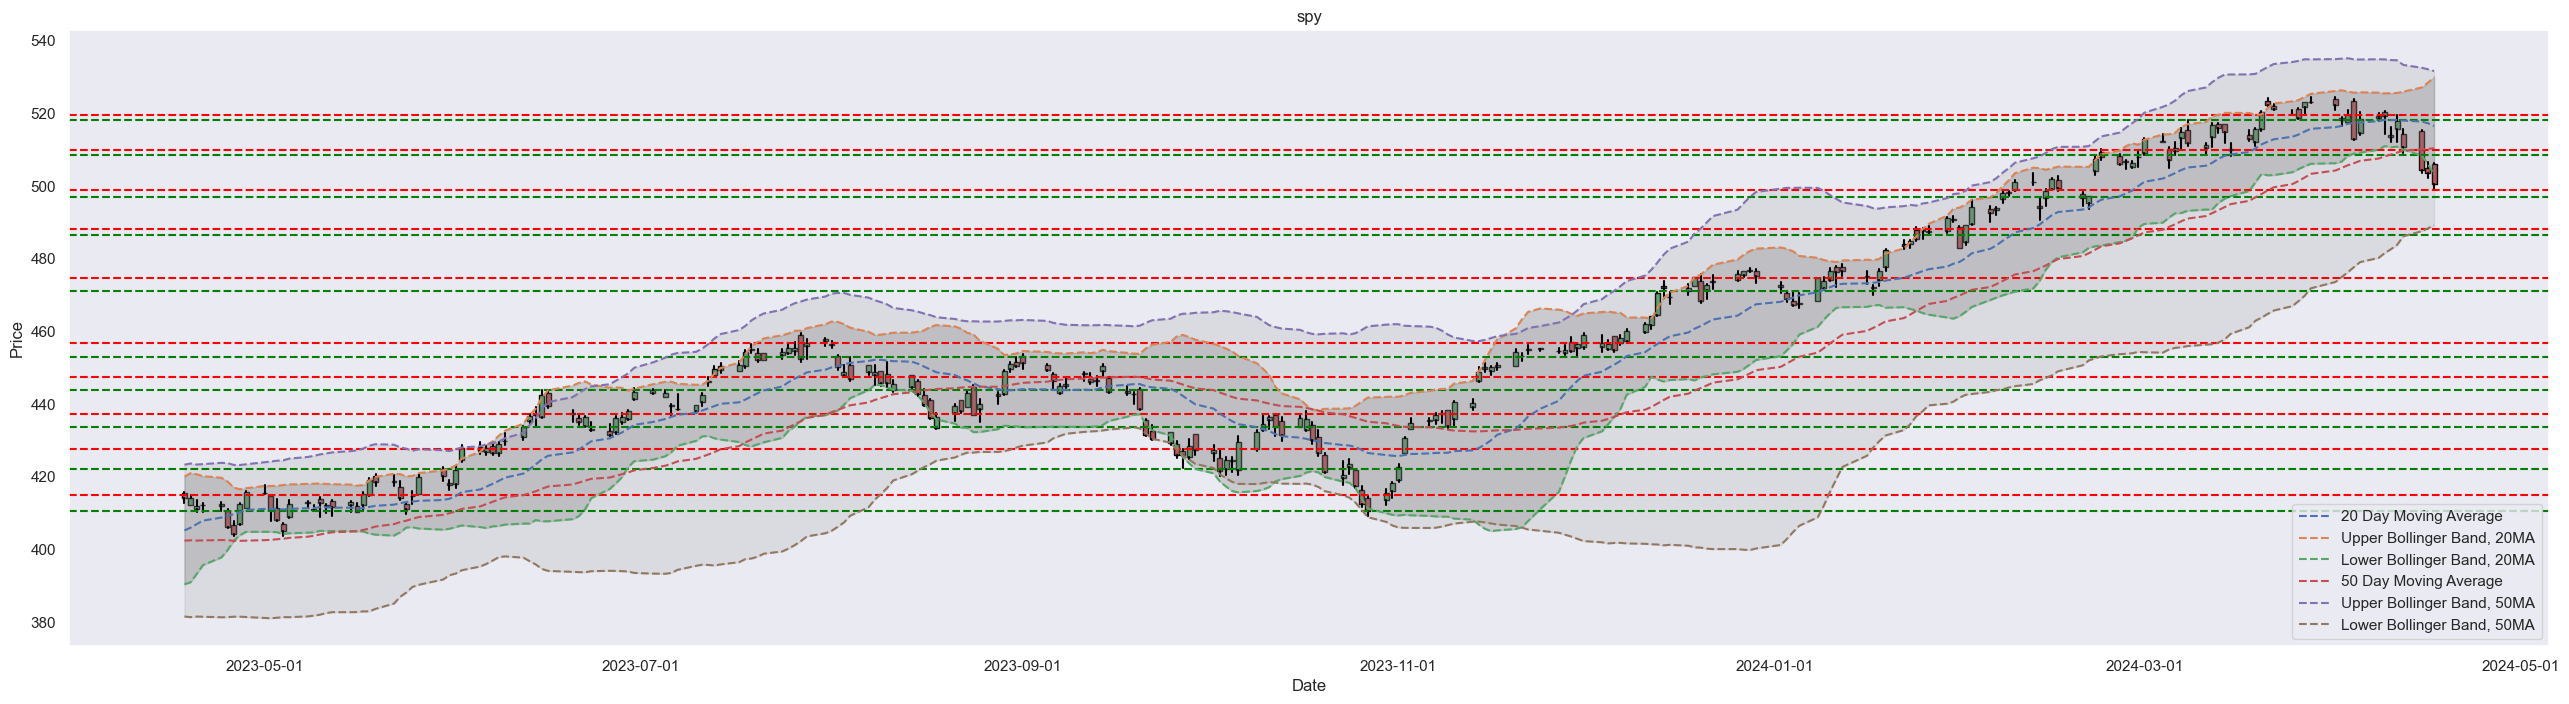

In [7]:
test_option_trading('spy')

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 61.26 ~ up 63.12 , down 58.15
Latest 20 Day MA: 67.79
Latest Lower Bollinger Band, 20MA: 62.14
Latest Higher Bollinger Band, 20MA: 73.44
Latest 50 Day MA: 65.79
Latest Lower Bollinger Band, 50MA: 58.23
Latest Higher Bollinger Band, 50MA: 73.36
Latest RSI: 23.02

[*********************100%%**********************]  1 of 1 completed
20MA break point: 67.68
20MA Lower Bollinger Band break point: 61.03
20MA Upper Bollinger Band break point: 74.33
50MA break point: 65.9
50MA Lower Bollinger Band break point: 57.9
50MA Upper Bollinger Band break point: 73.9
[[38.26860454]
 [41.8530307 ]
 [45.0721209 ]
 [47.54609764]
 [50.36133347]
 [53.49272693]
 [58.15928595]
 [61.6291666 ]
 [65.40521705]
 [69.0345452 ]]
[[39.3625    ]
 [42.98029428]
 [46.10666669]
 [48.33099995]
 [50.76842117]
 [54.55800034]
 [59.52999987]
 [63.11916701]
 [66.90631465]
 [69.89062595]]


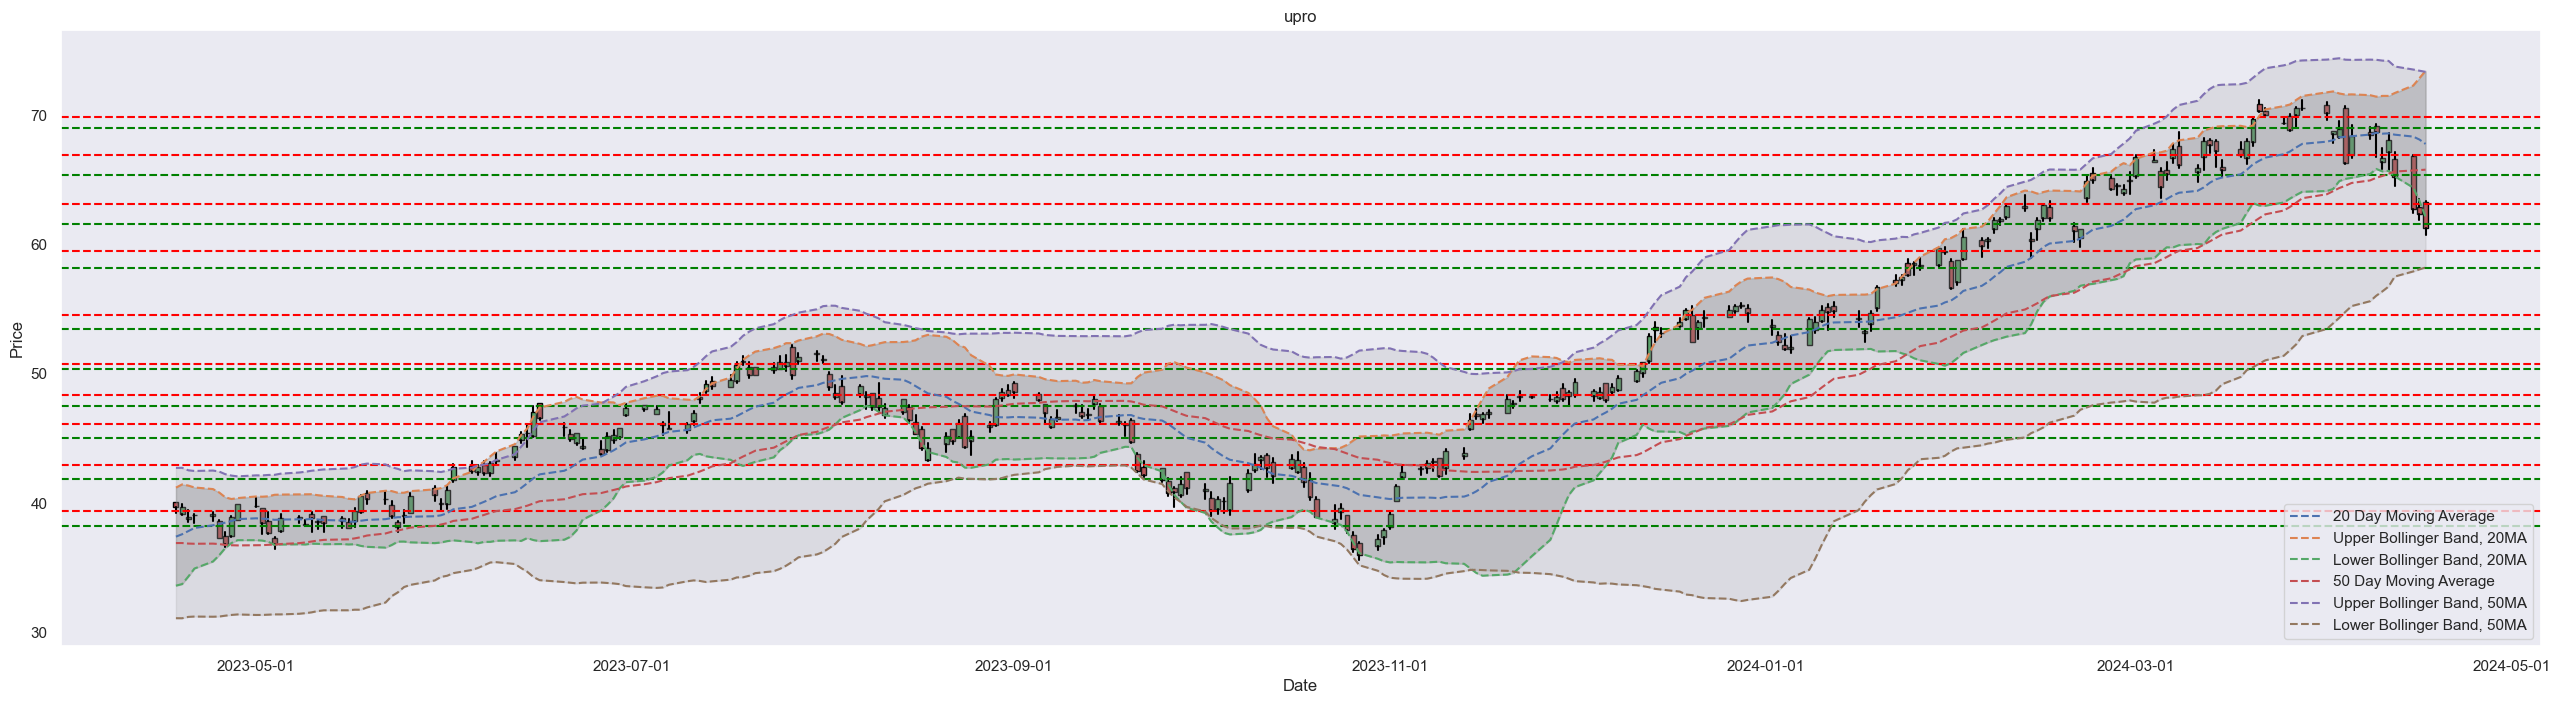

In [8]:
# 90% profit put: 60
test_option_trading('upro')

SOXX & SOXL

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 210.36 ~ up 214.25 , down 200.49
Latest 20 Day MA: 222.14
Latest Lower Bollinger Band, 20MA: 213.3
Latest Higher Bollinger Band, 20MA: 230.97
Latest 50 Day MA: 218.48
Latest Lower Bollinger Band, 50MA: 197.15
Latest Higher Bollinger Band, 50MA: 239.82
Latest RSI: 33.41

[*********************100%%**********************]  1 of 1 completed
20MA break point: 222.22
20MA Lower Bollinger Band break point: 211.73
20MA Upper Bollinger Band break point: 232.72
50MA break point: 218.88
50MA Lower Bollinger Band break point: 196.81
50MA Upper Bollinger Band break point: 240.94
[[136.3963485 ]
 [146.05472056]
 [156.01120461]
 [162.29016337]
 [169.80449007]
 [181.33333435]
 [191.25666809]
 [200.49066569]
 [211.796875  ]
 [222.40692139]]
[[139.35803084]
 [152.26066818]
 [162.31679932]
 [170.27944438]
 [177.81150055]
 [190.10650253]
 [202.92395782]
 [214.24844462]
 [225.04105863]
 [232.7670

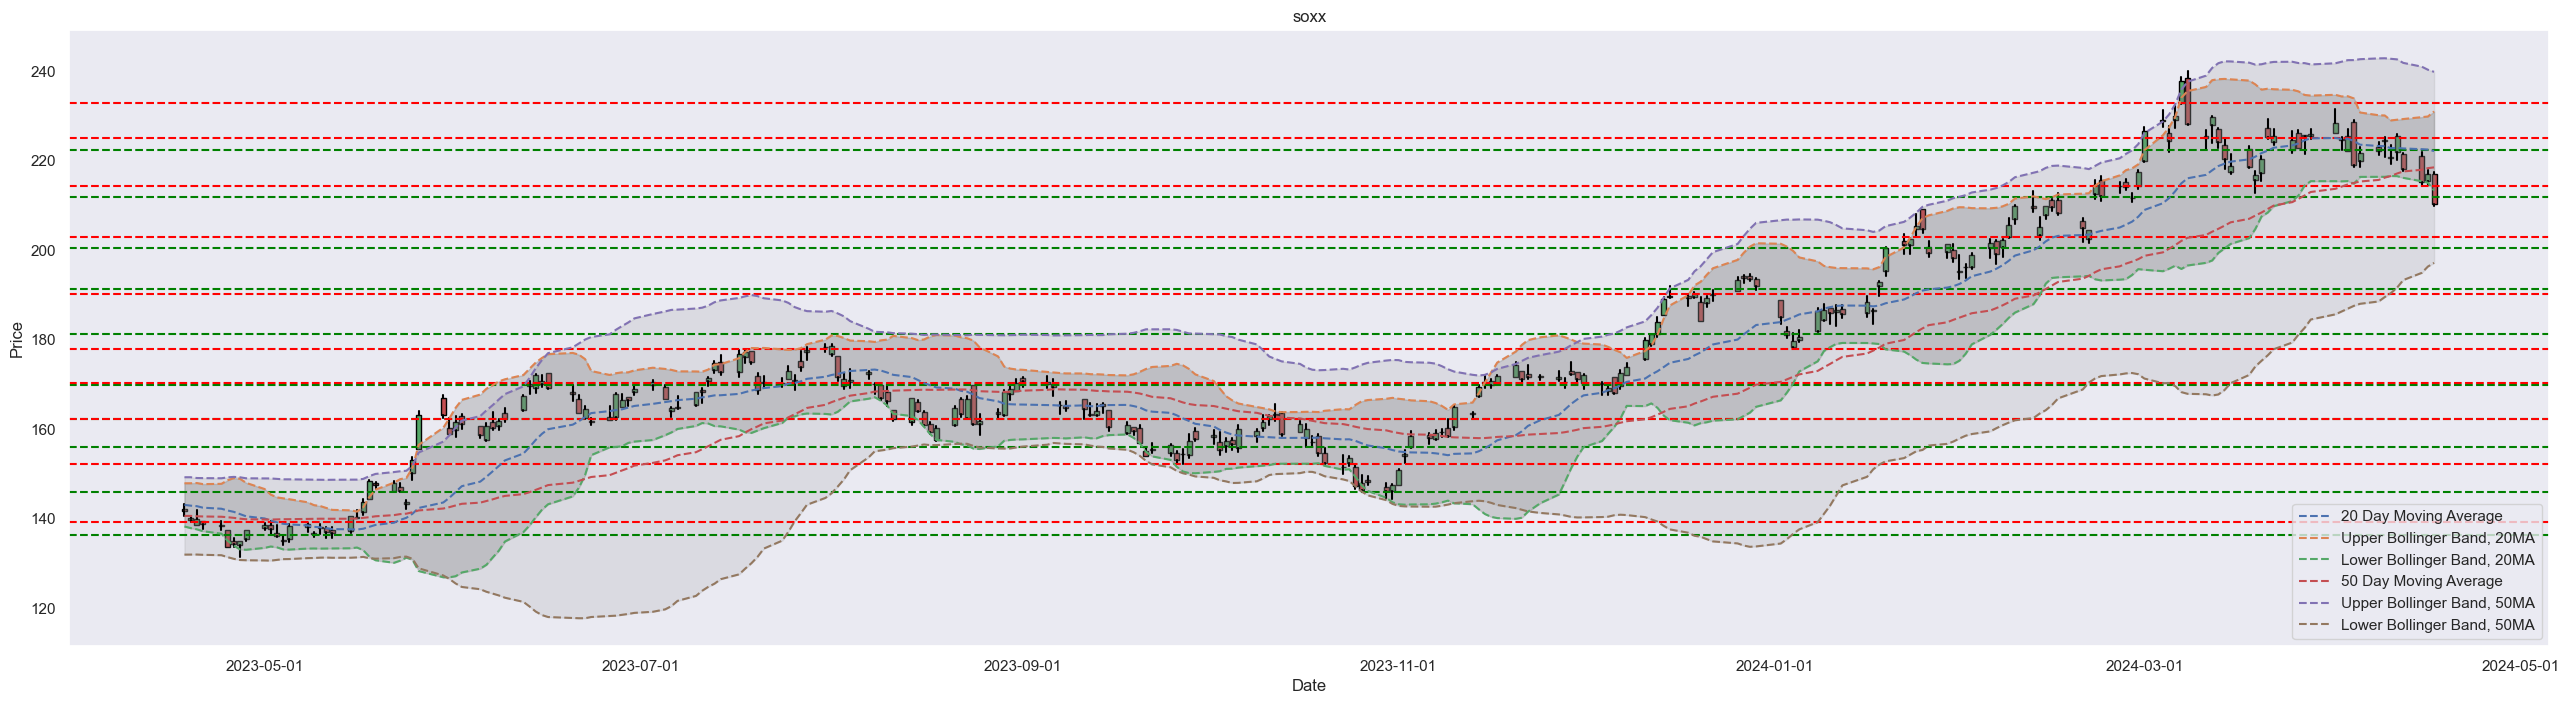

In [9]:
test_option_trading("soxx")

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 37.06 ~ up 39.38 , down 34.51
Latest 20 Day MA: 44.17
Latest Lower Bollinger Band, 20MA: 38.63
Latest Higher Bollinger Band, 20MA: 49.7
Latest 50 Day MA: 43.05
Latest Lower Bollinger Band, 50MA: 31.85
Latest Higher Bollinger Band, 50MA: 54.26
Latest RSI: 31.86

[*********************100%%**********************]  1 of 1 completed
20MA break point: 44.21
20MA Lower Bollinger Band break point: 37.62
20MA Upper Bollinger Band break point: 50.8
50MA break point: 43.24
50MA Lower Bollinger Band break point: 31.54
50MA Upper Bollinger Band break point: 54.95
[[14.21733335]
 [17.93175001]
 [21.27297872]
 [23.70684207]
 [26.7962501 ]
 [30.80357116]
 [34.51333313]
 [39.45941162]
 [44.02285694]
 [49.06800003]]
[[15.06703709]
 [19.02775002]
 [22.6427659 ]
 [25.30560987]
 [29.3592307 ]
 [34.5299999 ]
 [39.3718175 ]
 [42.88999993]
 [47.43149986]
 [54.07750034]]


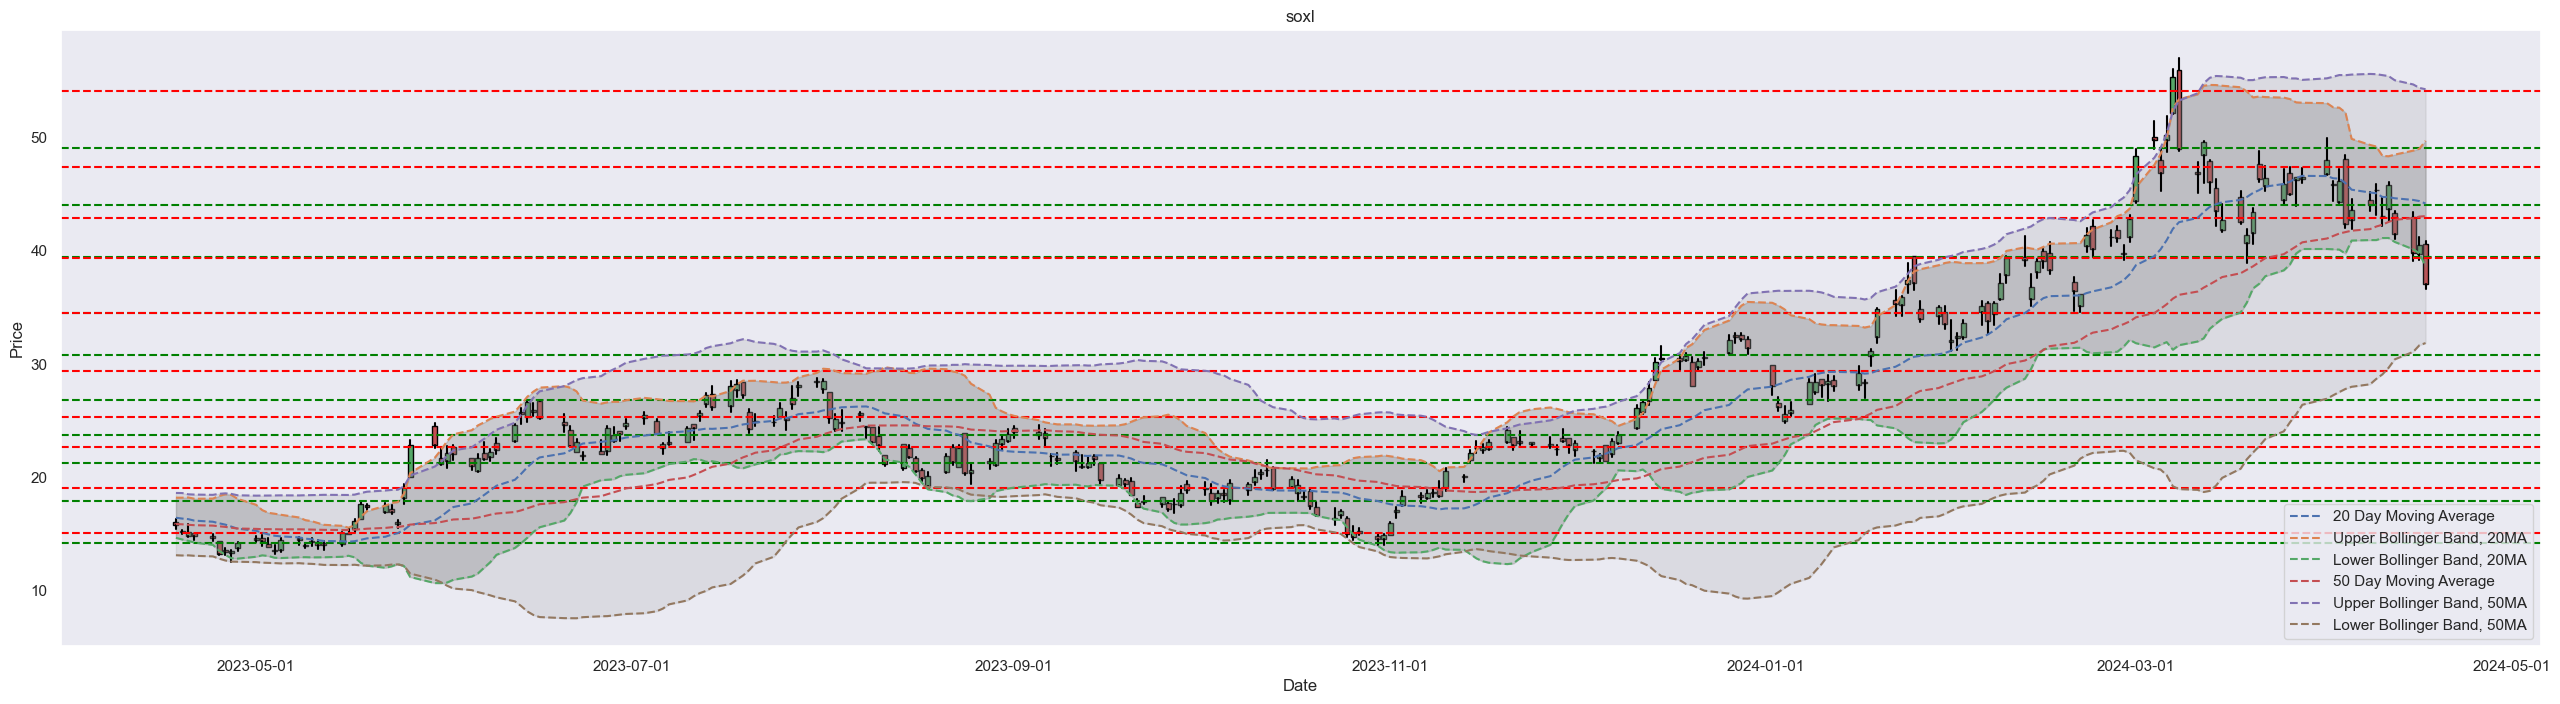

In [10]:
# 90% profit put: 36
test_option_trading("soxl")

NVDA & NVDL

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 840.35 ~ up 894.61 , down 774.8
Latest 20 Day MA: 891.37
Latest Lower Bollinger Band, 20MA: 833.29
Latest Higher Bollinger Band, 20MA: 949.44
Latest 50 Day MA: 835.96
Latest Lower Bollinger Band, 50MA: 637.87
Latest Higher Bollinger Band, 50MA: 1034.06
Latest RSI: 37.05

[*********************100%%**********************]  1 of 1 completed
20MA break point: 890.72
20MA Lower Bollinger Band break point: 821.78
20MA Upper Bollinger Band break point: 959.66
50MA break point: 839.1
50MA Lower Bollinger Band break point: 631.03
50MA Upper Bollinger Band break point: 1047.17
[[281.56814462]
 [405.95245073]
 [444.92245323]
 [479.22113731]
 [545.05125427]
 [608.22299805]
 [693.71916707]
 [774.80999756]
 [856.77523368]
 [899.4827215 ]]
[[289.73740641]
 [423.60131186]
 [463.15384439]
 [493.22119068]
 [557.35286168]
 [622.8490878 ]
 [719.97332764]
 [803.31143624]
 [894.60499711]
 [940.563

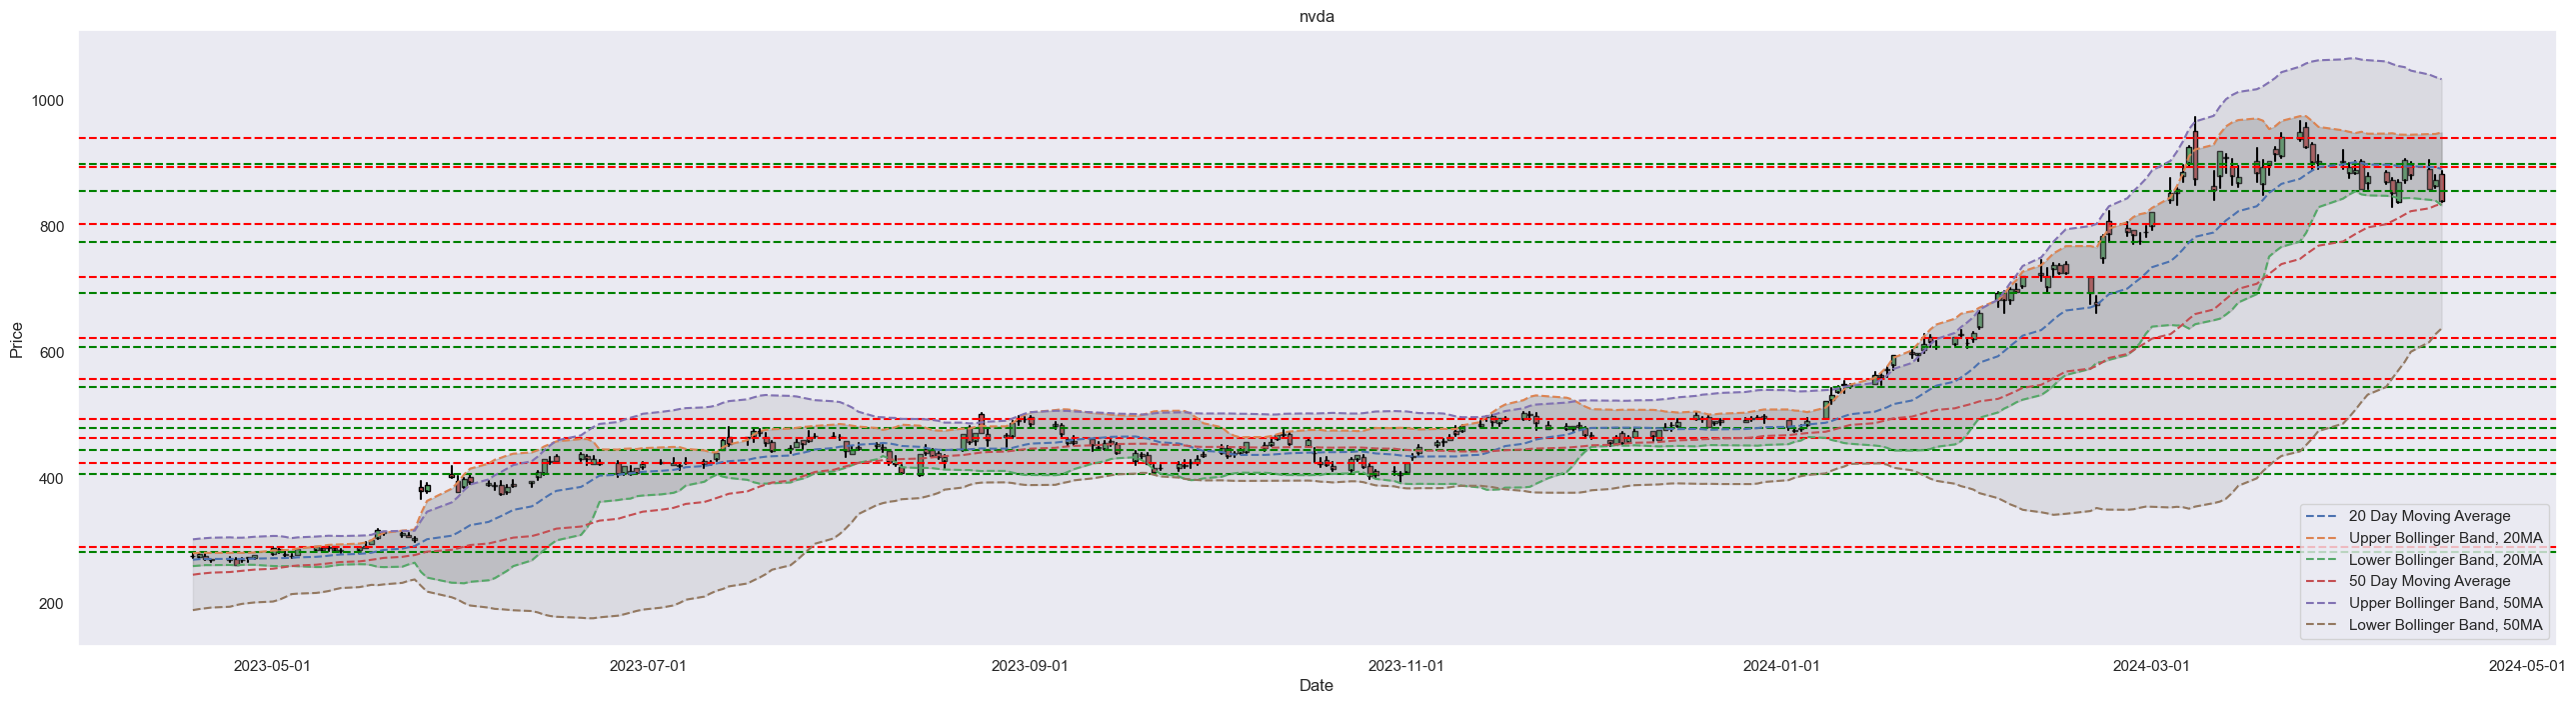

In [11]:
test_option_trading('nvda')

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 35.47 ~ up 39.34 , down 31.99
Latest 20 Day MA: 40.4
Latest Lower Bollinger Band, 20MA: 34.7
Latest Higher Bollinger Band, 20MA: 46.1
Latest 50 Day MA: 36.53
Latest Lower Bollinger Band, 50MA: 21.54
Latest Higher Bollinger Band, 50MA: 51.53
Latest RSI: 35.64

[*********************100%%**********************]  1 of 1 completed
20MA break point: 40.32
20MA Lower Bollinger Band break point: 33.57
20MA Upper Bollinger Band break point: 47.08
50MA break point: 36.76
50MA Lower Bollinger Band break point: 20.96
50MA Upper Bollinger Band break point: 52.56
[[14.4341253 ]
 [16.64041668]
 [20.31798363]
 [24.33499985]
 [27.63852024]
 [31.99269485]
 [35.74066696]
 [38.04911092]
 [40.16285651]
 [42.89673309]]
[[14.81011908]
 [17.09785438]
 [21.13958359]
 [26.09458319]
 [29.28857177]
 [33.87278639]
 [39.33250046]
 [41.6387693 ]
 [43.88486099]
 [47.64100075]]


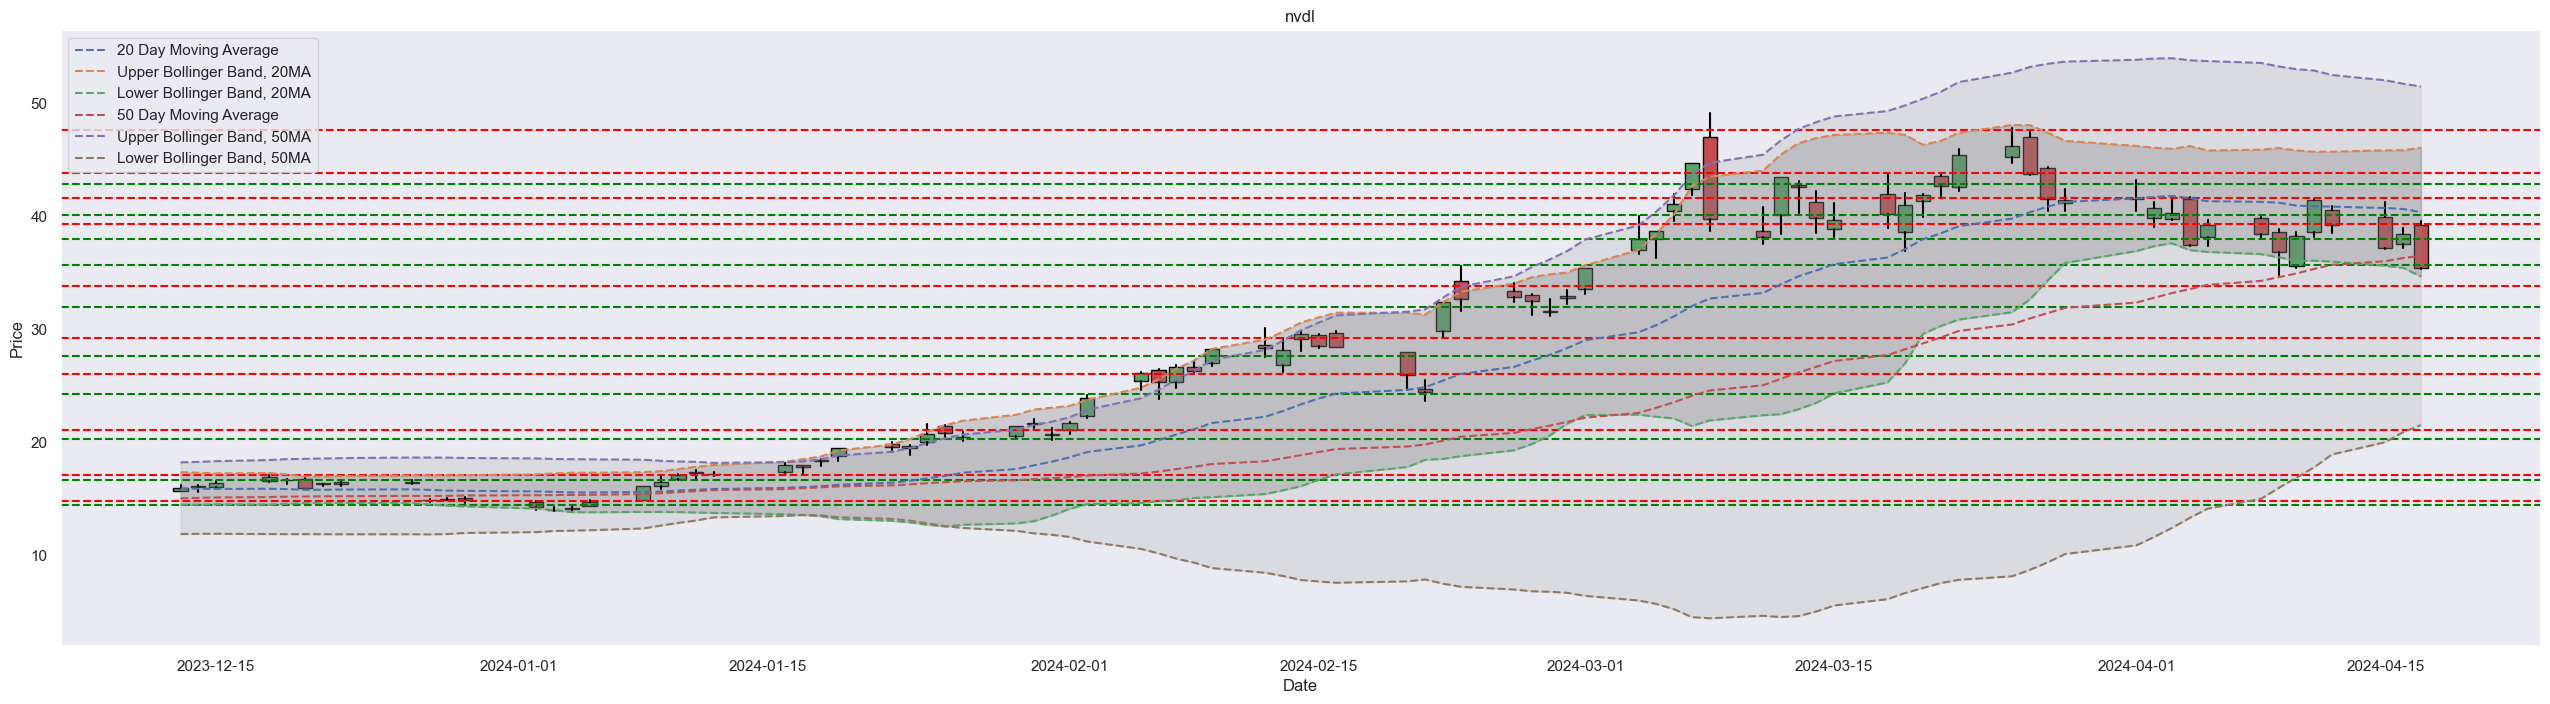

In [12]:
test_option_trading("nvdl")

Gld & UGL

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 219.59 ~ up 220.91 , down 216.26
Latest 20 Day MA: 211.11
Latest Lower Bollinger Band, 20MA: 196.13
Latest Higher Bollinger Band, 20MA: 226.1
Latest 50 Day MA: 199.95
Latest Lower Bollinger Band, 50MA: 171.5
Latest Higher Bollinger Band, 50MA: 228.4
Latest RSI: 75.66

[*********************100%%**********************]  1 of 1 completed
20MA break point: 211.58
20MA Lower Bollinger Band break point: 194.43
20MA Upper Bollinger Band break point: 228.74
50MA break point: 200.19
50MA Lower Bollinger Band break point: 169.39
50MA Upper Bollinger Band break point: 230.99
[[169.41428702]
 [174.1881811 ]
 [177.90416686]
 [181.17622274]
 [183.85102609]
 [187.50866801]
 [191.00125122]
 [199.83117766]
 [209.63800049]
 [216.26375008]]
[[169.83600159]
 [174.7563643 ]
 [178.75565239]
 [181.95526244]
 [184.71809496]
 [188.39819736]
 [192.08333333]
 [201.6238895 ]
 [213.09833272]
 [220.907141

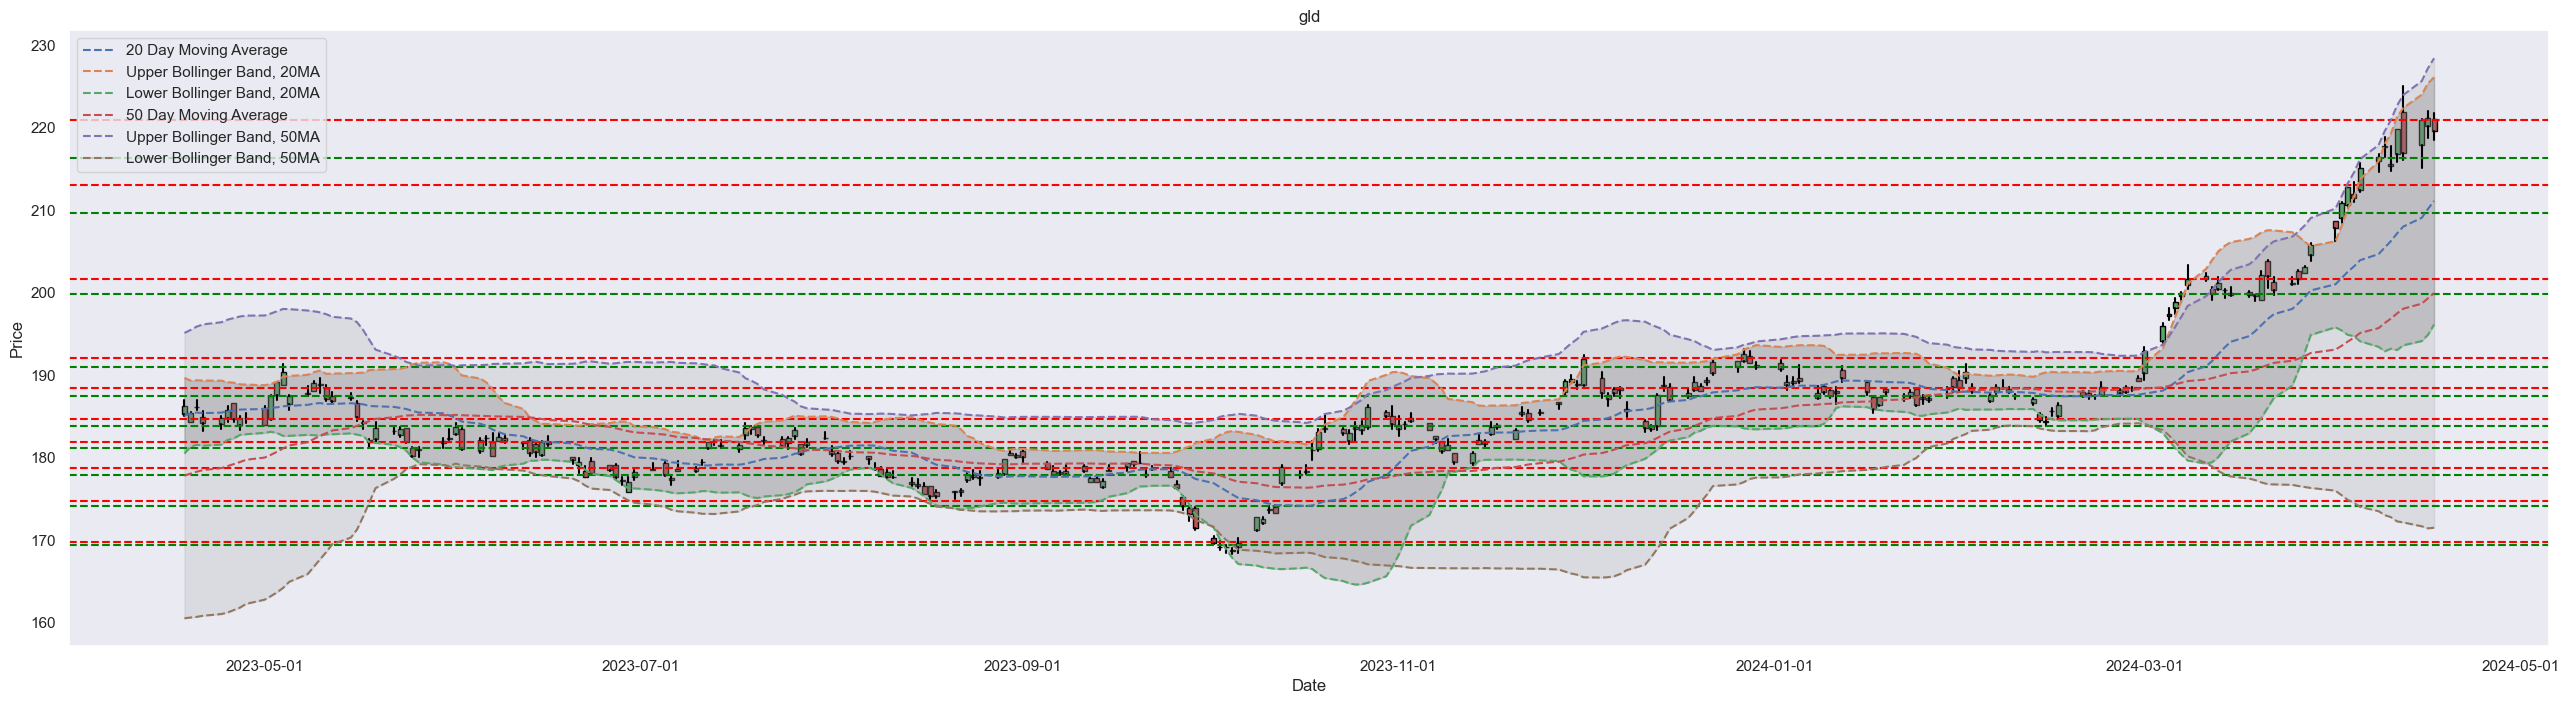

In [13]:
test_option_trading('gld')

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 81.97 ~ up 83.75 , down 79.61
Latest 20 Day MA: 76.09
Latest Lower Bollinger Band, 20MA: 65.69
Latest Higher Bollinger Band, 20MA: 86.49
Latest 50 Day MA: 68.74
Latest Lower Bollinger Band, 50MA: 49.92
Latest Higher Bollinger Band, 50MA: 87.57
Latest RSI: 75.04

[*********************100%%**********************]  1 of 1 completed
20MA break point: 76.42
20MA Lower Bollinger Band break point: 64.49
20MA Upper Bollinger Band break point: 88.34
50MA break point: 68.89
50MA Lower Bollinger Band break point: 48.49
50MA Upper Bollinger Band break point: 89.29
[[52.23416646]
 [56.60057155]
 [58.42275   ]
 [60.19018519]
 [61.48930208]
 [63.3876192 ]
 [65.53636308]
 [68.76875019]
 [75.01800079]
 [79.61749935]]
[[52.86636422]
 [57.3714704 ]
 [59.24578948]
 [61.15446138]
 [62.8975004 ]
 [65.27250036]
 [69.5852629 ]
 [76.33500099]
 [80.45499802]
 [83.74599915]]


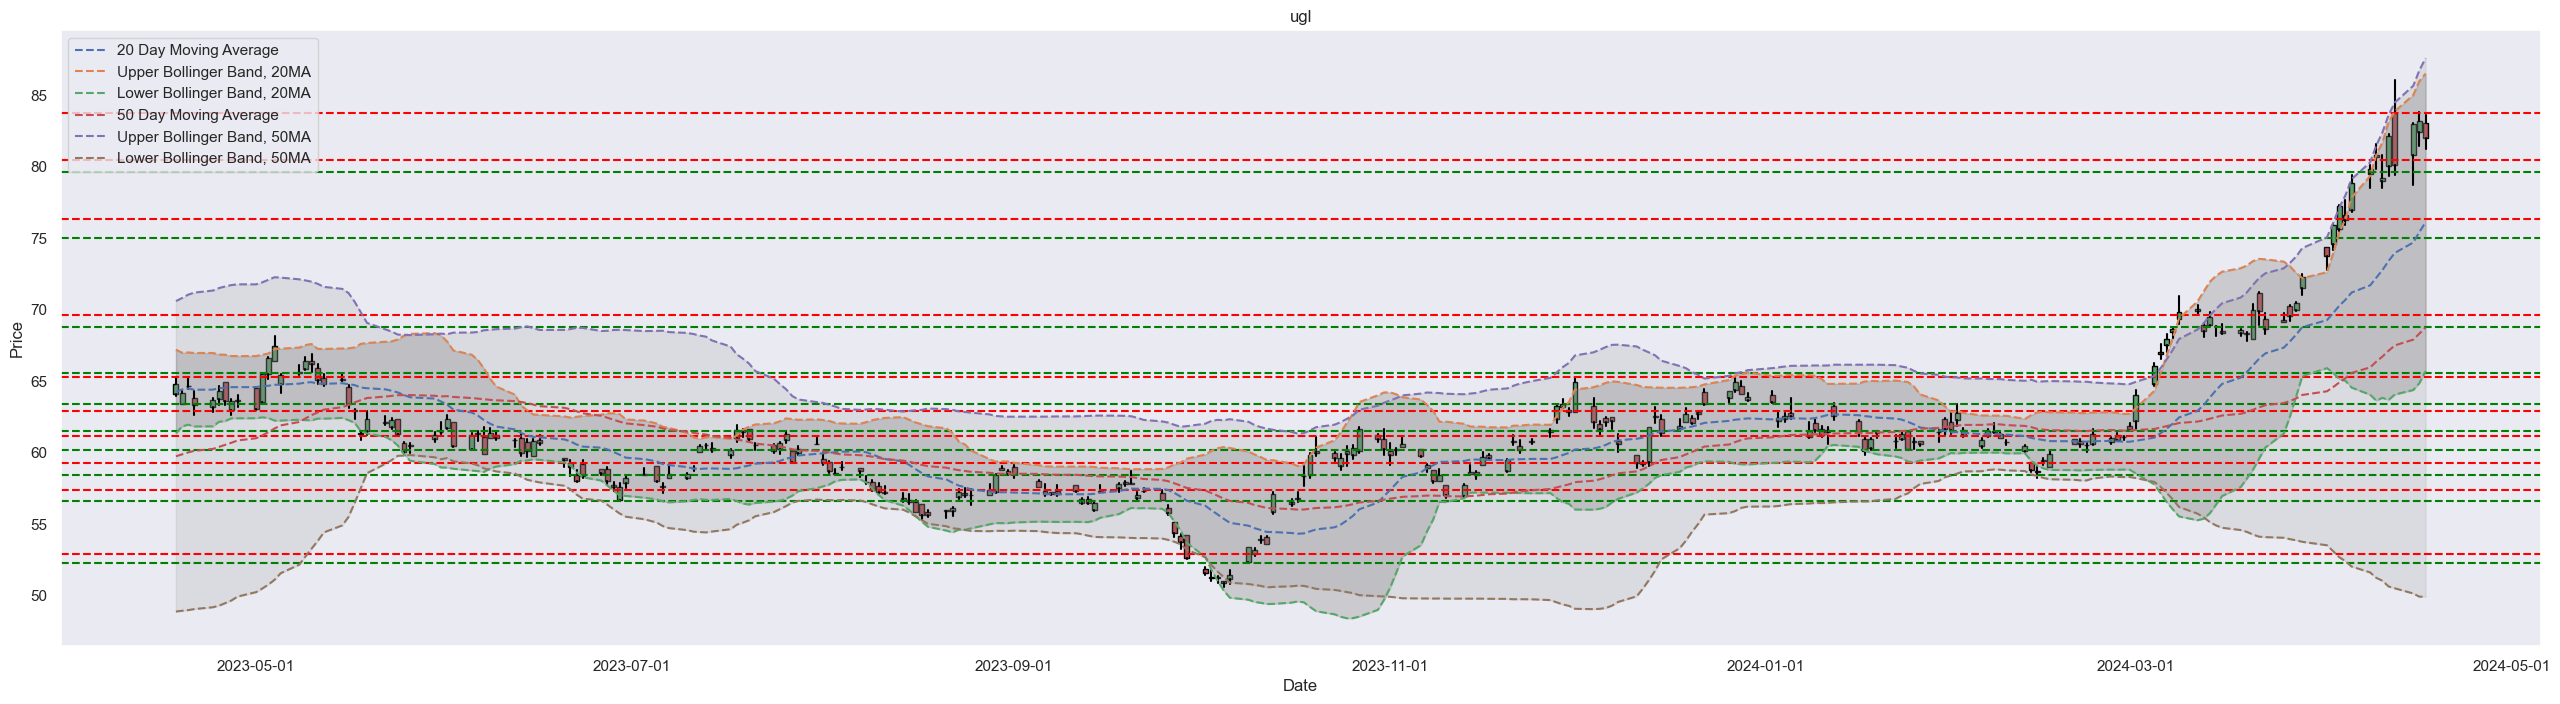

In [14]:
test_option_trading('ugl')

Random stocks

[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 155.45 ~ up 163.17 , down 120.6
Latest 20 Day MA: 170.64
Latest Lower Bollinger Band, 20MA: 157.43
Latest Higher Bollinger Band, 20MA: 183.85
Latest 50 Day MA: 180.18
Latest Lower Bollinger Band, 50MA: 148.39
Latest Higher Bollinger Band, 50MA: 211.97
Latest RSI: 30.64

[*********************100%%**********************]  1 of 1 completed
20MA break point: 170.37
20MA Lower Bollinger Band break point: 154.87
20MA Upper Bollinger Band break point: 185.88
50MA break point: 180.08
50MA Lower Bollinger Band break point: 145.35
50MA Upper Bollinger Band break point: 214.8
[[120.60333379]
 [162.7716059 ]
 [179.5807142 ]
 [193.79282969]
 [211.7532759 ]
 [231.34544081]
 [246.41958279]
 [266.03852492]
 [291.4511365 ]
 [329.08667603]]
[[125.04499855]
 [163.16470561]
 [181.72675674]
 [199.27728642]
 [221.85164073]
 [241.29692359]
 [257.41897387]
 [277.98850359]
 [304.46119036]
 [344.70167

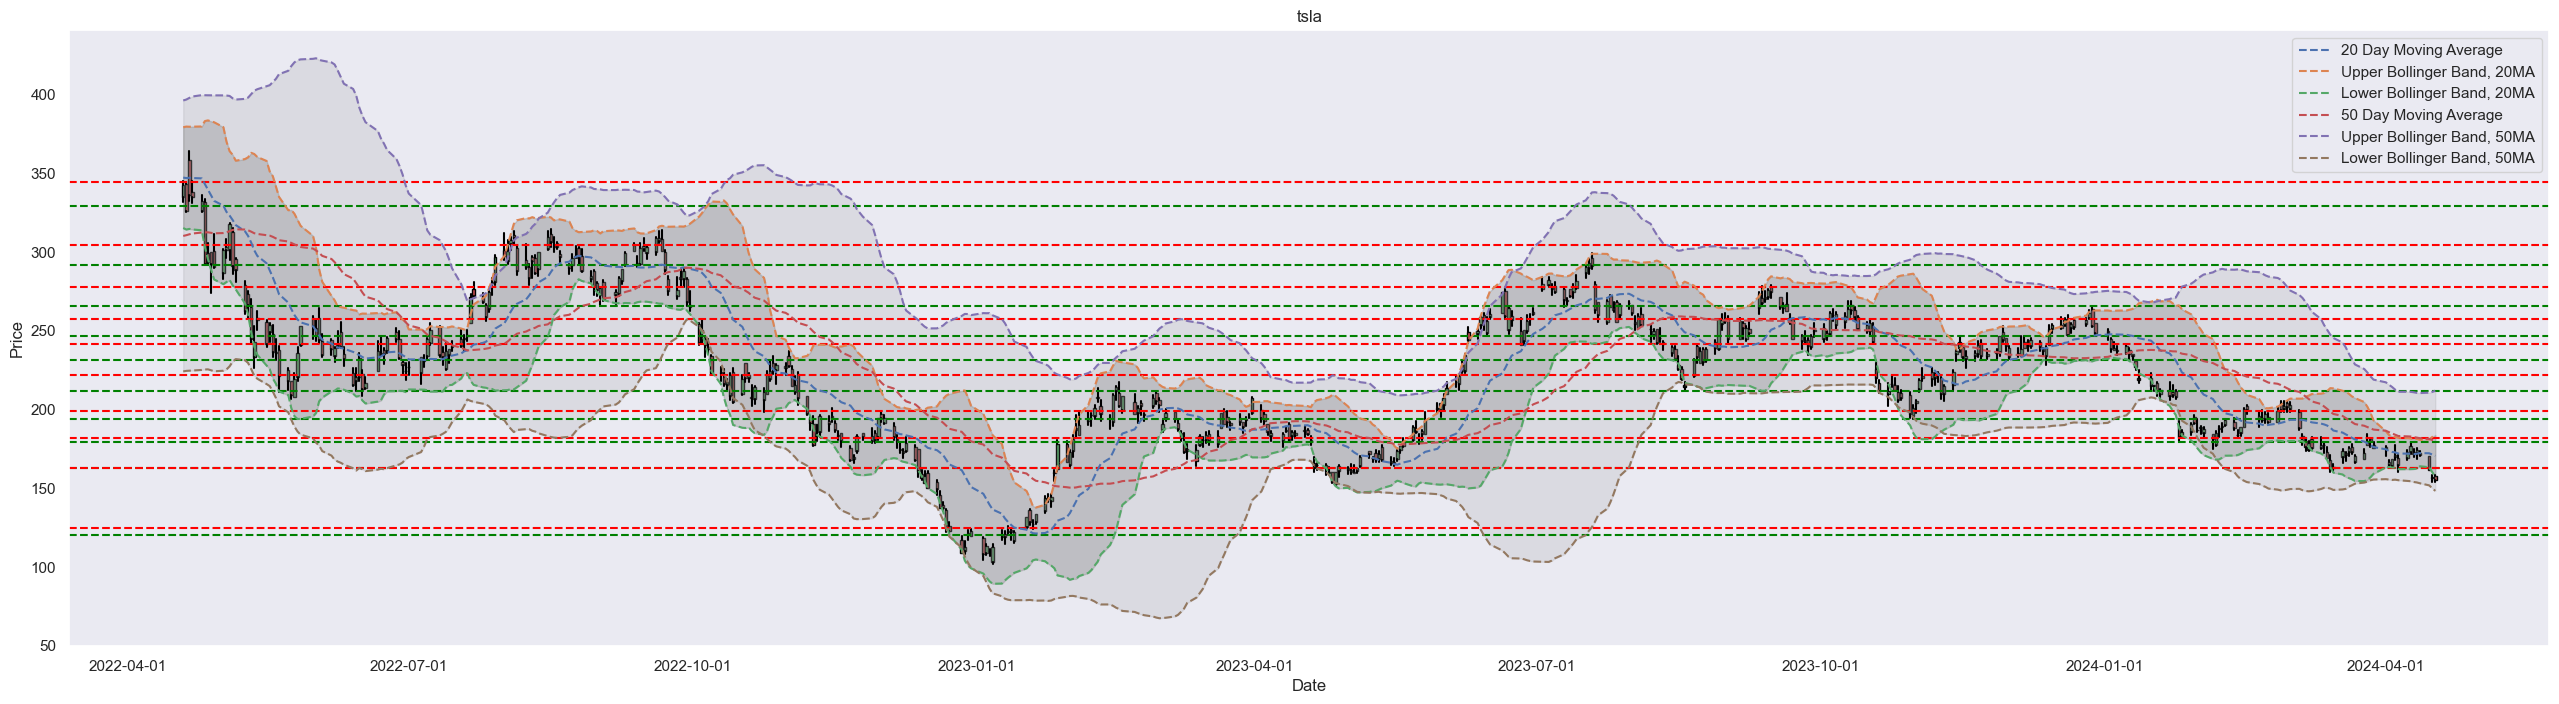

In [15]:
test_option_trading('tsla', start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d'))

In [16]:
def test_option_trading_fbtc(
                        start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
                        end=datetime.today().strftime('%Y-%m-%d')
                       ):
    df = yf.download('BTC-USD', start=start, end=end)
    df = df.reset_index()
    df_fbtc = yf.download('fbtc', start=start, end=end)
    df_fbtc = df_fbtc.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    df_merged = pd.merge(df[['Date','Open','High', 'Low','Close']],
                  df_fbtc[['Date','Open','High', 'Low','Close']],
                  on='Date')
    s1 = df_merged['Close_x']
    s2 = df_merged['Close_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['Close'] = theta_best[0] + theta_best[1]*df['Close']

    s1 = df_merged['Open_x']
    s2 = df_merged['Open_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['Open'] = theta_best[0] + theta_best[1]*df['Open']

    s1 = df_merged['Low_x']
    s2 = df_merged['Low_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['Low'] = theta_best[0] + theta_best[1]*df['Low']

    s1 = df_merged['High_x']
    s2 = df_merged['High_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['High'] = theta_best[0] + theta_best[1]*df['High']

    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['50 Day MA'] = df['Close'].rolling(window=50).mean()
    df['50 Day STD'] = df['Close'].rolling(window=50).std()    
    # Calculate upper and lower bands
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)

    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df_plot = df[df['Date'] >= df['Date'].min() + relativedelta(years=1)]

    low_clusters = get_optimum_clusters(df_plot[(df_plot['Low']!=df_plot['Open'])&(df_plot['Low']!=df_plot['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df_plot[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df_plot[(df_plot['High']!=df_plot['Open'])&(df_plot['High']!=df_plot['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df_plot[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df_plot.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df_plot['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df_plot['High'].max()


    close = df_plot.iloc[-1]['Close']
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print("Latest 20 Day MA:", round(df_plot['20 Day MA'].tolist()[-1],2))
    print("Latest Lower Bollinger Band, 20MA:", round(df_plot['Lower Band - 20MA'].tolist()[-1],2))
    print("Latest Higher Bollinger Band, 20MA:", round(df_plot['Upper Band - 20MA'].tolist()[-1],2))
    print("Latest 50 Day MA:", round(df_plot['50 Day MA'].tolist()[-1],2))
    print("Latest Lower Bollinger Band, 50MA:", round(df_plot['Lower Band - 50MA'].tolist()[-1],2))
    print("Latest Higher Bollinger Band, 50MA:", round(df_plot['Upper Band - 50MA'].tolist()[-1],2))  

    
    latest_rsi = round(df['RSI'].tolist()[-1], 2)
    if latest_rsi > 70:
        print("Latest RSI:", Fore.RED + str(latest_rsi))
    elif latest_rsi < 30:
        print("Latest RSI:", Fore.GREEN + str(latest_rsi))
    else:
        print("Latest RSI:", latest_rsi)
        
    print(Style.RESET_ALL)
    break_point_solution("fbtc")
    
    print(low_centers)
    print(high_centers)

    ax = plot_candlestick(df_plot, figsize=(32,8))
    ax.set_title('FBTC')
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')
    # df_plot['5_MA'] = df_plot['Close'].rolling(window=5).mean()
    # df_plot['9_MA'] = df_plot['Close'].rolling(window=9).mean()
    # df_plot['20_MA'] = df_plot['Close'].rolling(window=20).mean()
    # df_plot['50_MA'] = df_plot['Close'].rolling(window=50).mean()

    # ax.plot(df_plot['Date'], df_plot['Close'], color='black')
    # ax.plot(df_plot['Date'], df_plot['5_MA'], ls='--')

    # ax.plot(df_plot['Date'], df_plot['9_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['20_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['50_MA'], ls='--')
    ax.plot(df_plot['Date'], df_plot['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 20MA'], df_plot['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
    ax.plot(df_plot['Date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
2024-04-18
* previous stock price closing 53.54 ~ up 55.9 , down 43.0
Latest 20 Day MA: 59.08
Latest Lower Bollinger Band, 20MA: 53.99
Latest Higher Bollinger Band, 20MA: 64.18
Latest 50 Day MA: 58.76
Latest Lower Bollinger Band, 50MA: 51.82
Latest Higher Bollinger Band, 50MA: 65.71
Latest RSI: 40.54

[*********************100%%**********************]  1 of 1 completed
20MA break point: 59.02
20MA Lower Bollinger Band break point: 52.59
20MA Upper Bollinger Band break point: 65.45
50MA break point: 54.72
50MA Lower Bollinger Band break point: 35.16
50MA Upper Bollinger Band break point: 74.27
[[14.62958571]
 [17.37758119]
 [20.06298273]
 [23.3592747 ]
 [25.86982052]
 [32.28822217]
 [36.96564886]
 [43.0065399 ]
 [54.89228732]
 [60.06468755]]
[[15.7191054 ]
 [18.67094143]
 [21.34208886]
 [24.4396697 ]
 [26.9425518 ]
 [33.4221954 ]
 [37.9356924 ]
 [43.2

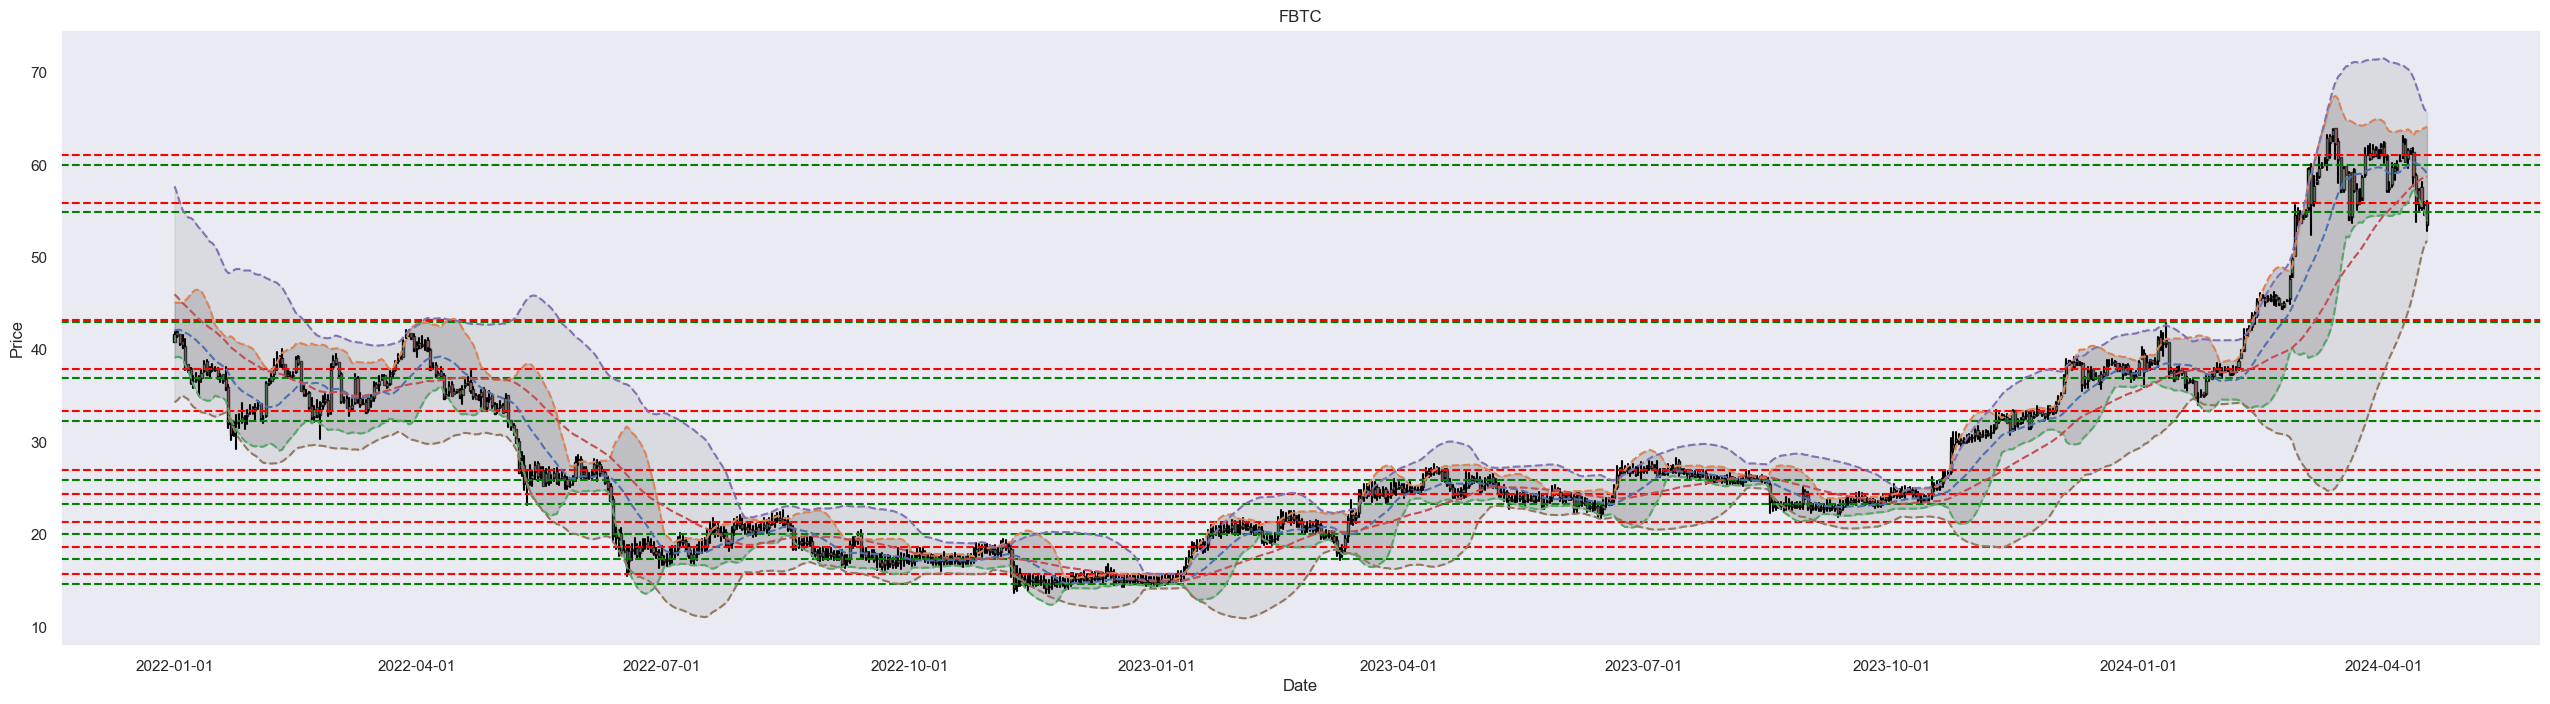

In [17]:
test_option_trading_fbtc(start='2021-01-01')

In [18]:
# # Double check...
# stock_name = 'fbtc'
# df = yf.download(stock_name.upper(),
#              start=(datetime.today() - relativedelta(days=100)).strftime('%Y-%m-%d'),
#              end=datetime.today()
#              )
# df = df.reset_index()
# df.columns = df.columns.str.lower()
# last_19day_price = df['close'][-20:-1]
# last_49day_price = df['close'][-50:-1]
# print(np.mean(np.append(last_19day_price, 59.25)))
# print(np.mean(np.append(last_49day_price, 54.4)))
# print(np.mean(np.append(last_19day_price, 53.6)) - 2*np.std(np.append(last_19day_price, 53.6), ddof=1))
# print(np.mean(np.append(last_19day_price, 64.89)) + 2*np.std(np.append(last_19day_price, 64.89), ddof=1))
# print(np.mean(np.append(last_49day_price, 33.78)) - 2.5*np.std(np.append(last_49day_price, 33.78), ddof=1))
# print(np.mean(np.append(last_49day_price, 75.02)) + 2.5*np.std(np.append(last_49day_price, 75.02), ddof=1))
